## Appendix (Application of the mutual fund theorem)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import pandas as pd


ticker_list = ['069500']
df_list = [fdr.DataReader(ticker, '2015-01-01', '2016-12-31')['Change'] for ticker in ticker_list]

df = pd.concat(df_list, axis=1)
#df.columns = ['005930', '000660', '005935', '035420', '005380', '207940', '012330', '068270', '051910', '055550', '069500']
df.columns = ['KODEX200']

r = df.dropna()
rf = 0.0125


#df = df.resample('Y').agg(lambda x:x.mean()*252)

# Calculate basic summary statistics for individual stocks
stock_volatility = r.std() * np.sqrt(252)
stock_return = r.mean() * 252

alpha = stock_return.values
sigma = stock_volatility.values

In [5]:
# cov_inv = np.linalg.inv(cov)
# temp = np.dot(cov_inv, (stock_return- rf))
# theta_opt = temp / temp.sum() # optimal weight in Risky Mutual fund

# alpha = np.dot(theta_opt, stock_return) # 0.5941
# sigma = np.sqrt(cov.dot(theta_opt).dot(theta_opt))

## (5B), (7B)

In [2]:
# g_B = 0 # in case of age over retirement (Second scenario in Problem(B))
X0 = 150. # Saving account at the beginning
l = 3
t = 45 # age in case of age over retirement (Second scenario in Problem(B))
gamma = -3. # risk averse measure

phi = rf + (alpha -rf)**2 / (2 * sigma**2 * (1-gamma)) # temporal function for f_B
rho = 0.04 # impatience factor for utility function
beta = 4.59364 # parameter for mu
delta = 0.05032 # parameter for mu
rf=0.02

def f_B(t):
    
    if t < 65:
        ds = 0.01
        T = 65
        T_tilde = 110
        value = 0
    
        for s in np.arange(T, T_tilde, ds):
            w_s = np.exp(-rho*s/(1-gamma))
            tmp = (10**(beta + delta*s - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
            value += np.exp(-1/(1-gamma)*(tmp - gamma*tmp - gamma*phi *(s-t))) * w_s * ds
            
        f = np.exp(-1/(1-gamma) *(tmp - gamma*tmp + gamma*phi*(T-t))) * value
        
        return f
    
    else: # 65~
        ds = 0.01
        T_tilde = 110
        value = 0

        for s in np.arange(t, T_tilde, ds):
            w_s = np.exp(-rho*s/(1-gamma))
            tmp = (10**(beta + delta*s - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
            value += np.exp(-1/(1-gamma)*(tmp - gamma*tmp - gamma*phi *(s-t))) * w_s * ds
        
        return value


# def f_B(t):
#     ds = 0.01
#     T_tilde = 110
#     value = 0
    
#     for s in np.arange(t, T_tilde, ds):
#         w_s = np.exp(-rho*s/(1-gamma))
#         tmp = (10**(beta + delta*s - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
#         value += np.exp(- tmp + gamma/(1-gamma) * phi *(s-t)) * w_s * ds
#     return value

# def V_B(t, x):
#     f_b = f_B(t)
#     value_fcn = 1/gamma * f_b **(1-gamma) * x **gamma
#     return value_fcn

def C_star(t,X):
    w_t = np.exp(-rho*t/(1-gamma))
    f_b = f_B(t)
    c_t = w_t/f_b * X
    return c_t

def g_B(t, l):
    
    ds=0.01
    value = 0.
    T=65 # retirement
    
    if t < T:
        for s in np.arange(t, T, ds):
            tmp = (10**(beta + delta*s - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
            value += np.exp(-tmp)*l * ds
        return value
    
    else:
        return 0.


pi_opt  = (alpha-rf)/(sigma**2 *(1-gamma)) * (X0 + g_B(t, l))/X0 # Optimal weight for Risky Asset (7B)

print(pi_opt) # 0.25
# print(C_star(t, X))

[0.83630489]


## Simulation

In [3]:
import time

start = time.time()

dt = 1

def mu(t): # Mortality rate in next year
    value = (10**(beta + delta*(t+dt) - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
    return value

n_simulation = 10000

Asset = np.empty(37)
Asset_stack = []
C_stack = []

for i in range(n_simulation):
    Asset[0] = 150 # initial wealth
    C_list = []
    
    for t in range(45, 81):
        
        if t < 65: # before retirement
            
            l_t = 3 # payment to pension fund
            pi_opt  = (alpha-rf)/(sigma**2 *(1-gamma)) * (Asset[t-45] + g_B(t, l_t))/Asset[t-45]
            C_t = 0 # 
            Z = np.random.randn()

            Asset[t-45+1] = Asset[t-45]*np.exp(((1-pi_opt)*rf + pi_opt*alpha + mu(t)+ l_t/Asset[t-45] \
                                         -pi_opt**2 * sigma**2/2)*dt + pi_opt * sigma * np.sqrt(dt) * Z)
            
        else : # after retirement
            
            l_t = 0 # payment duty is 0 after retirement
            pi_opt  = (alpha-rf)/(sigma**2 *(1-gamma)) * (Asset[t-45] + g_B(t, l_t))/Asset[t-45]
            C_t = C_star(t=t, X = Asset[t-45])
            Z = np.random.randn()

            Asset[t-45+1] = Asset[t-45]*np.exp(((1-pi_opt)*rf + pi_opt*alpha + mu(t)- C_t/Asset[t-45] \
                                         -pi_opt**2 * sigma**2/2)*dt + pi_opt * sigma * np.sqrt(dt) * Z)
            C_list.append(C_t)


    Asset_stack.append(list(Asset))
    C_stack.append(C_list)

end = time.time()
print(end - start)

12911.317305803299


## Check the Simulation Result

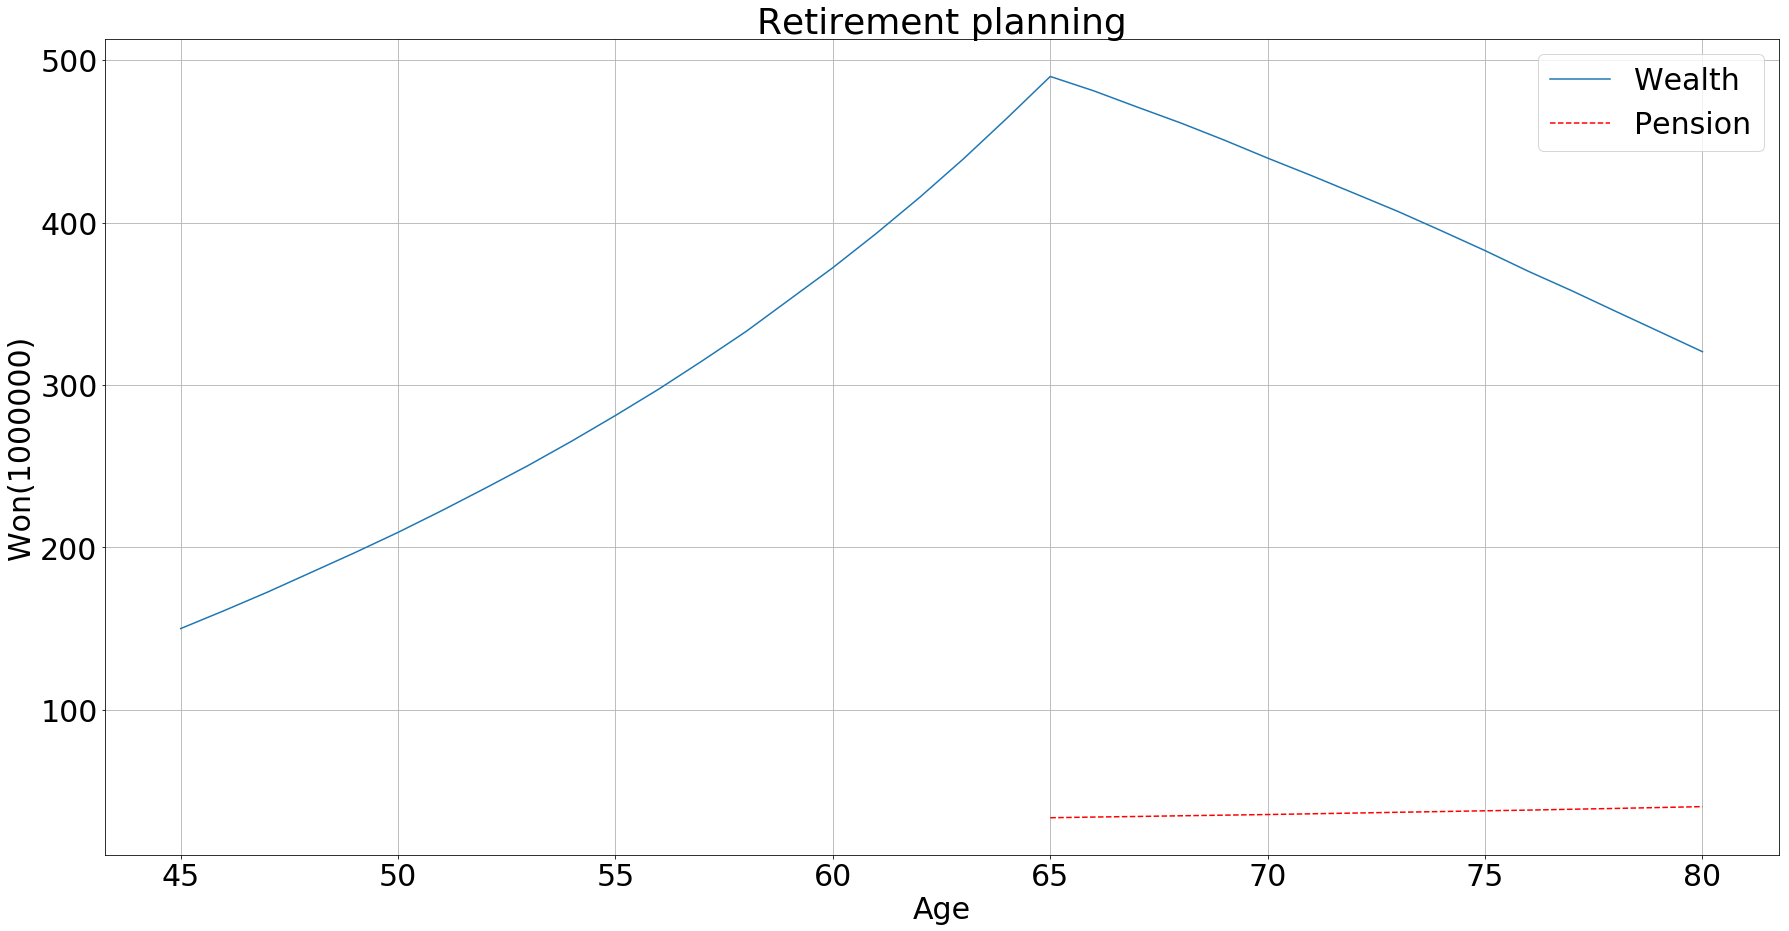

In [5]:
Asset_mean = np.mean(Asset_stack, axis=0) #(37,)
C_mean = np.mean(C_stack, axis=0) # (16,1)

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 30})

plt.title('Retirement planning')
plt.xlabel('Age')
plt.ylabel('Won(1000000)')
plt.plot(range(45,81),Asset_mean[:-1], label='Wealth')
plt.plot(range(65,81),C_mean, '--', color = 'r', label="Pension")
plt.legend()
plt.grid()

In [22]:
pi_opt_list=[]
for t in range(45, 81):
    if t < 65:
        l_t = 3
    else :
        l_t = 0
    pi_opt = (alpha-rf)/(sigma**2 *(1-gamma)) * (Asset_mean[:-1][t-45] + g_B(t, l_t))/Asset_mean[:-1][t-45]
    pi_opt_list.append(pi_opt)

<BarContainer object of 36 artists>

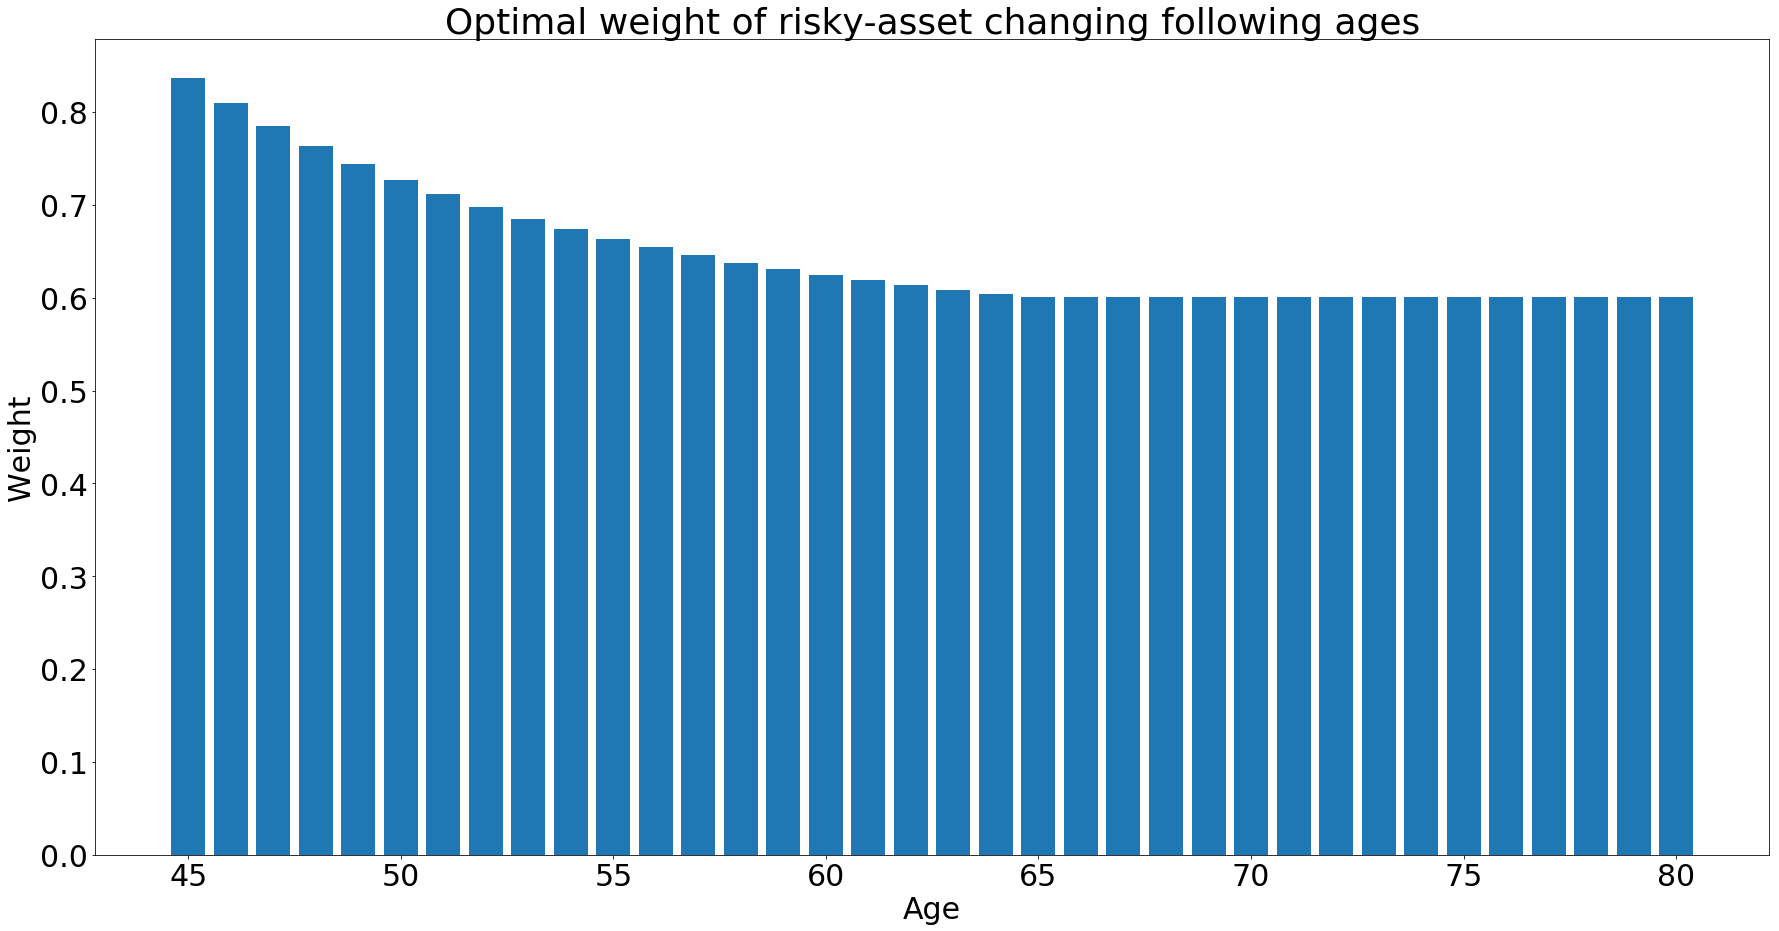

In [30]:
plt.title('Optimal weight of risky-asset changing following ages')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.bar(range(45,81),np.array(pi_opt_list).squeeze())